In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 42.4 MB/s eta 0:00:00


#P1


In [ ]:
#hola como estan este es una prueba de guardado en github

#P2


In [240]:
#@title Funciones útiles (no editar)
import numpy as np
import matplotlib.pyplot as plt

def generador_puntos_separados(n,seed=42):

  np.random.seed(seed)
  group1 = np.random.randn(n, 2)
  group2 = np.random.randn(n, 2) + [4, 4]
  X = np.vstack([group1, group2])
  y = np.hstack([np.zeros(n)-1, np.ones(n)])
  return X,y

def generador_puntos_mezclados(n,seed=42):
  np.random.seed(seed)
  group1 = np.random.randn(n, 2)
  group2 = np.random.randn(n, 2) + [1,2]
  X = np.vstack([group1, group2])
  y = np.hstack([np.zeros(n)-1, np.ones(n)])
  return X,y

def graficar(X,y,w=None,b=None):
  plt.figure(figsize=(8, 6))
  if w is not None and b is not None:
    x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]),100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    plt.plot(x_vals, y_vals, 'k-', label='Hiperplano separante')

  group1 = X[y == -1]
  group2 = X[y == 1]
  plt.scatter(group1[:, 0], group1[:, 1], color='blue', label='Group 1')
  plt.scatter(group2[:, 0], group2[:, 1], color='red', label='Group 2')


  # Add titles and labels
  plt.title('Separación de dos grupos')
  plt.xlabel('x_1')
  plt.ylabel('x_2')
  plt.legend()
  plt.show()

In [133]:
from gurobipy import*

In [134]:
#para esta parte es mejor utilizar el problema de minimización, donde minimizartemos min w,b 0,5||w||^2
#sujeto a w^t x_i + b >= 1

In [233]:
def SVM_Hard(X,y):
  #detectamos la dimensión de X:
  n,d = X.shape #Esto entregara el numero de muestra y además la dimensión del vector.

  model = Model('SVM_hard')
  model.setParam('OutputFlag',0)

  #ahora debemos definir las variables:
  #dado que el problema está minimizando dos variables, w y b necesitamos definir dos variables

  w = model.addVars(d, lb =- GRB.INFINITY, name = 'w') #w tiene que ser de dimención d puesto que x lo es
  b = model.addVar(lb = -GRB.INFINITY, name = 'b') # Dado que se realiza un producto punto en la restricción este es de dimención 1

  model.update() #guardamos las actualizaciones del modelo.

  #función objetivo:

  model.setObjective(gp.quicksum(w[j]*w[j] for j in range(d)) * 0.5, GRB.MINIMIZE)
  #esto minimiza la funcion objetivo que planteamos en a).

  #aplicamos la restriccion:

  for i in range(n):
      model.addConstr( y[i] * (quicksum(w[j]*X[i, j] for j in range(d)) + b) >= 1,name=f"margin_{i}")

  #Optimizamos:
  model.optimize()

  w_optimo = np.array([w[j].x for j in range(d)])
  b_optimo = b.x

  return w_optimo, b_optimo


In [225]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def SVM_Hard(X, y):
    n, d = X.shape  # n puntos, d dimensiones

    # Creamos el modelo
    model = gp.Model("SVM_Hard")
    model.setParam('OutputFlag', 0)  # Silenciar la salida de Gurobi

    # Variables
    w = model.addVars(d, lb=-GRB.INFINITY, name="w")
    b = model.addVar(lb=-GRB.INFINITY, name="b")

    # Objetivo: minimizar 0.5 * ||w||^2 = 0.5 * sum(w_i^2)
    model.setObjective(gp.quicksum(w[j]*w[j] for j in range(d)) * 0.5, GRB.MINIMIZE)

    # Restricciones: y_i * (w^T x_i + b) >= 1
    for i in range(n):
        model.addConstr(
            y[i] * (gp.quicksum(w[j]*X[i, j] for j in range(d)) + b) >= 1,
            name=f"margin_{i}"
        )

    # Optimizar
    model.optimize()

    # Obtener solución
    w_sol = np.array([w[j].X for j in range(d)])
    b_sol = b.X
    return w_sol, b_sol


In [295]:
#Ejemplo
X, y = generador_puntos_separados(320)
w, b = SVM_Hard(X, y)
print (w)
print (b)

[17.7782489  16.67685771]
-74.40810083492589


In [307]:
#función para graficar SVM-Hard
def graficar_SVM(X, y, w, b):
    plt.figure(figsize=(8,6))

    # Puntos por clase
    clase1 = y == 1
    clase2 = y == -1
    plt.scatter(X[clase1][:, 0], X[clase1][:, 1], color='blue', label='Clase +1')
    plt.scatter(X[clase2][:, 0], X[clase2][:, 1], color='red', label='Clase -1')

    # Crear rejilla de valores para trazar hiperplano
    x_vals = np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, 200)
    w1, w2 = w
    b = b

    # Hiperplano: w1*x + w2*y + b = 0 ⇒ y = -(w1*x + b)/w2
    if w2 != 0:
        hiperplano = -(w1 * x_vals + b) / w2
        margen_sup = -(w1 * x_vals + b - 1) / w2
        margen_inf = -(w1 * x_vals + b + 1) / w2

        plt.plot(x_vals, hiperplano, 'k-', label='Hiperplano Separante')
        plt.plot(x_vals, margen_sup, 'k--', linewidth=0.8)
        plt.plot(x_vals, margen_inf, 'k--', linewidth=0.8)
        plt.fill_between(x_vals, margen_sup, margen_inf, color='blue', alpha=0.1, label='Margen')

    else:
        # En caso de que w2 = 0, el hiperplano es vertical: x = -b/w1
        x_const = -b / w1
        plt.axvline(x=x_const, color='k', label='Hiperplano Separante')
        plt.axvline(x=x_const + 1/w1, color='k', linestyle='--', linewidth=0.8)
        plt.axvline(x=x_const - 1/w1, color='k', linestyle='--', linewidth=0.8)
        plt.axvspan(x_const - 1/w1, x_const + 1/w1, color='blue', alpha=0.1, label='Margen')

    plt.legend()
    plt.title("SVM Hard")
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.grid(False)
    plt.show()


[0.52784999 0.54116752]


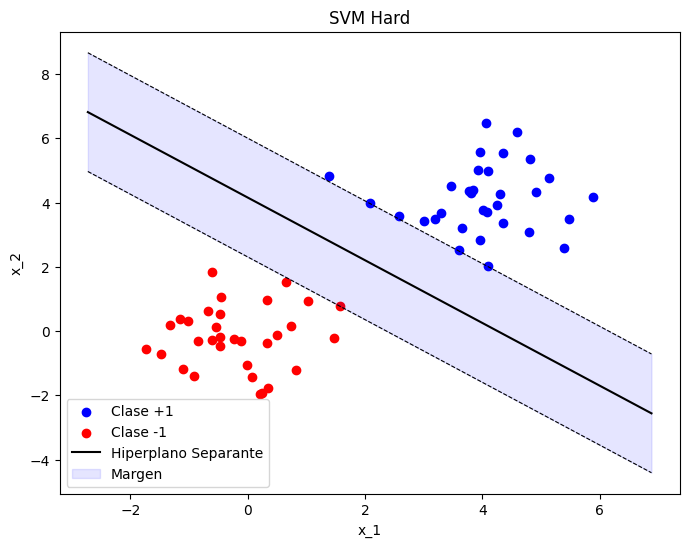

In [308]:
X, y = generador_puntos_separados(32)
w, b = SVM_Hard(X, y)
print (w)
graficar_SVM(X, y, w, b)


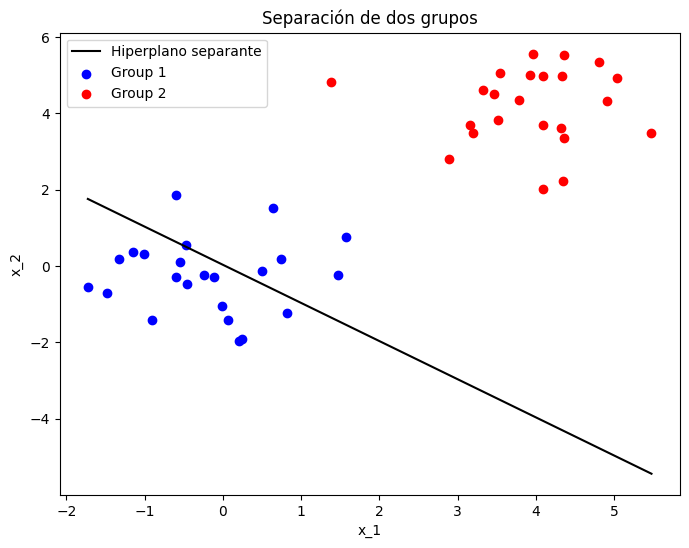

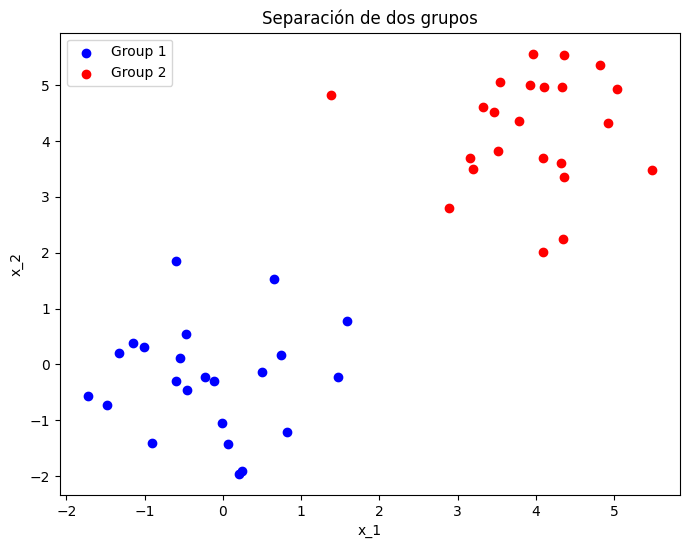

In [302]:
#Ejemplo:
X,y=generador_puntos_separados(23)
graficar(X,y,(3,3),-0.1) # Con hiperplano
graficar(X,y) # Sin hiperplano

## b)


##d)